# Tumor Detection
---

In [36]:
import os
import matplotlib.pyplot as plt
import PIL
import random
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
from tqdm.notebook import tqdm

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/miniconda3/envs/AI/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.2
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd versi

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print gpu name
if torch.cuda.is_available(): 
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_properties(device='cuda'))

Using device: cuda
NVIDIA GeForce RTX 3090
_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24257MB, multi_processor_count=82, uuid=e7c31494-7e41-d1c4-a803-f28dc77117f5, L2_cache_size=6MB)


Unzip the data

In [38]:
data_path = Path("data")
train_path = data_path / "NCT-CRC-HE-100K"
test_path = data_path / "CRC-VAL-HE-7K"

train_zip = data_path / "NCT-CRC-HE-100K.zip"
test_zip = data_path / "CRC-VAL-HE-7K.zip"

In [39]:
# Unzip data
import zipfile

# If data is not unzipped
if not os.path.exists(train_path):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Train data unzipped")

if not os.path.exists(test_path):
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(data_path)
        print("Test data unzipped")

Change image format

In [40]:
# Change format from .tif to .jpg
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith('.tif'):
            img = Image.open(os.path.join(root, file))
            img.save(os.path.join(root, file.replace('.tif', '.jpg')))
            os.remove(os.path.join(root, file))

### Reproducibility

In [41]:
# Random seed
seed = 42

np.random.seed(seed)
random.seed(seed)
set_determinism(seed=seed)

## Train data and Data Balancing

In [42]:
training_data = {}
for train_dir_path in train_path.iterdir():
    if not train_dir_path.is_dir():
        continue
    training_files = list(train_dir_path.iterdir())
    training_data[train_dir_path.name] = training_files
    print(f"{train_dir_path.name:>5} {len(training_files)}")

  LYM 11557
 BACK 10566
  DEB 11512
  MUC 8896
  MUS 13536
  STR 10446
  TUM 14317
  ADI 10407
 NORM 8763


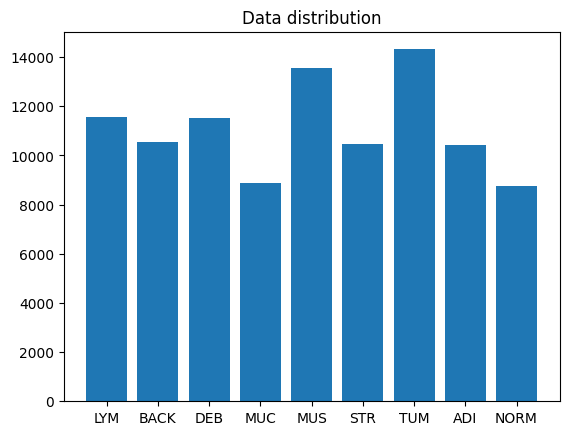

In [43]:
plt.figure()
plt.bar(training_data.keys(), [len(v) for v in training_data.values()])
plt.title("Data distribution")
plt.show()

In [44]:
class_names = ["healthy", "tumor"]
num_class = len(class_names)
image_files = [[], []]

image_files[1] = training_data["TUM"]
num_positives = len(image_files[1])
num_negative_classes = len(training_data)-1

for k, v in training_data.items():
    if k == "TUM":
        continue
    print(f"{k:<10} Pick {num_positives//num_negative_classes + 1} out of {len(v)}") 
    image_files[0].extend(random.sample(v, num_positives//num_negative_classes + 1))
    
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

LYM        Pick 1790 out of 11557
BACK       Pick 1790 out of 10566
DEB        Pick 1790 out of 11512
MUC        Pick 1790 out of 8896
MUS        Pick 1790 out of 13536
STR        Pick 1790 out of 10446
ADI        Pick 1790 out of 10407
NORM       Pick 1790 out of 8763
Total image count: 28637
Image dimensions: 224 x 224
Label names: ['healthy', 'tumor']
Label counts: [14320, 14317]


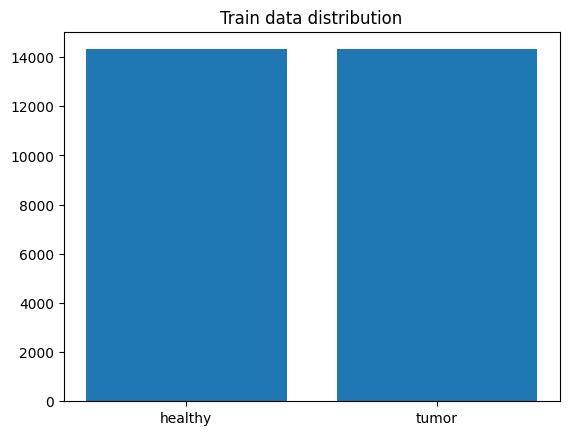

In [45]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Train data distribution")
plt.show()

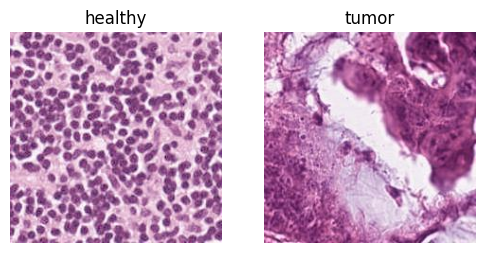

In [46]:
# Plot an image from each class
plt.figure(figsize=(6, 4))
for i in range(num_class):
    plt.subplot(1, num_class, i + 1)
    plt.imshow(PIL.Image.open(image_files[i][0]))
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

## Prepare training and validation splits

Training count: 22910, Validation count: 5727


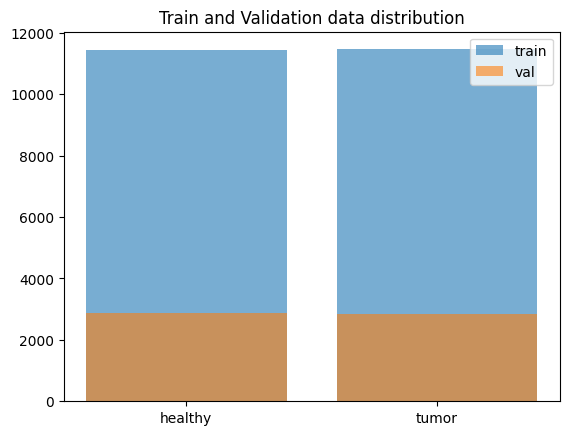

In [47]:
val_frac = 0.2
length = len(image_files_list)
indices = np.arange(length)
# Set seed for reproducibility
np.random.seed(seed)
np.random.shuffle(indices)

val_split = int(val_frac * length)
val_indices = indices[:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]

print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}")

# Plot train and validation data distribution
plt.figure()
plt.bar(class_names, [train_y.count(i) for i in range(num_class)], alpha=0.6, label="train")
plt.bar(class_names, [val_y.count(i) for i in range(num_class)], alpha=0.6, label="val")
plt.title("Train and Validation data distribution")
plt.legend()
plt.show()

## Define transforms, Dataset and Dataloader to pre-process data

Preprocess and data augmentation:

In [48]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        # Data augmentation:
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

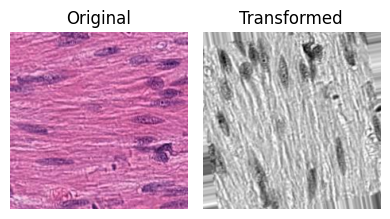

In [49]:
# Example of original and transformed image
plt.figure(figsize=(4, 4))

trans = train_transforms(train_x[1])
orig = PIL.Image.open(train_x[1])

plt.subplot(1, 2, 1)
plt.imshow(orig)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(trans[0], cmap="gray")
plt.title("Transformed")
plt.axis("off")
plt.tight_layout()
plt.show()

In [50]:
class TissuesDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = TissuesDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=10)
print("Number of train batches:", len(train_loader))

val_ds = TissuesDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, num_workers=10)
print("Number of validation batches:", len(val_loader))

Number of train batches: 358
Number of validation batches: 90


## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.  
1. Use DenseNet from MONAI and move to GPU device.
1. Use Adam optimizer.

In [51]:
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=num_class, pretrained=True).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

print("Model created")

Model created


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.  
Will save the model weights to file if got best validation metric.

In [52]:
models_path = "models/"

In [53]:
TRAINING = False
if TRAINING:
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []
    torch.cuda.empty_cache()
    for epoch in range(max_epochs):
    #    print("-" * 10)
    #    print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch + 1} Training", leave=True)
        for batch_data in train_progress:
            step += 1
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    #        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
    #    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                val_progress = tqdm(val_loader, desc=f"Epoch {epoch + 1} Validation", leave=True)
                for val_data in val_progress:
                    val_images, val_labels = (
                        val_data[0].to(device),
                        val_data[1].to(device),
                    )
                    y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
                y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
                auc_metric(y_pred_act, y_onehot)
                result = auc_metric.aggregate()
                auc_metric.reset()
                del y_pred_act, y_onehot
                metric_values.append(result)
                acc_value = torch.eq(y_pred.argmax(dim=1), y)
                acc_metric = acc_value.sum().item() / len(acc_value)
                if result > best_metric:
                    best_metric = result
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(models_path, "binary_balanced_model.pth"))
                print(
                    f"Epoch: {epoch + 1} Validation AUC: {result:.4f}"
                    f" Validation accuracy: {acc_metric:.4f}"
                    f" Best AUC: {best_metric:.4f} at epoch: {best_metric_epoch}"
                )
    
    print("---")
    print(f"Training completed")
    print(f"Best validation AUC: {best_metric:.4f} at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [54]:
if TRAINING:
    plt.figure("train", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(epoch_loss_values))]
    y = epoch_loss_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.subplot(1, 2, 2)
    plt.title("Val AUC")
    x = [val_interval * (i + 1) for i in range(len(metric_values))]
    y = metric_values
    plt.xlabel("epoch")
    plt.plot(x, y)
    plt.show()

## Evaluation with test data

In [55]:
class_names = ["healthy", "tumor"]
num_class = len(class_names)
folders = sorted(os.listdir(test_path))
test_image_files = [[], []]

# Separate dataset into healthy and tumor
for i in range(len(folders)):
    for file in os.listdir(os.path.join(test_path, folders[i])):
        if folders[i] == "TUM":
            test_image_files[1].append(os.path.join(test_path, folders[i], file))
        else:
            test_image_files[0].append(os.path.join(test_path, folders[i], file))

num_each = [len(test_image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(test_image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 7180
Image dimensions: 224 x 224
Label names: ['healthy', 'tumor']
Label counts: [5947, 1233]


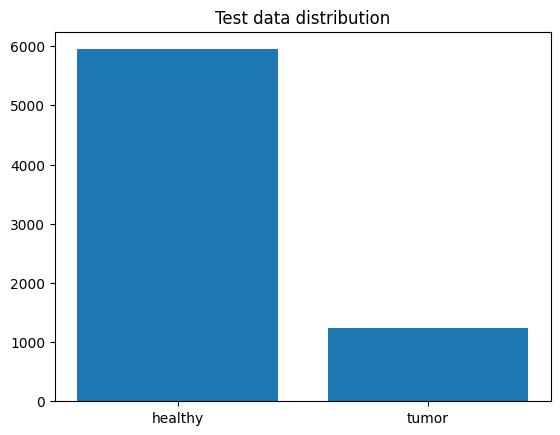

In [56]:
# Plot train data distribution
plt.figure()
plt.bar(class_names, num_each)
plt.title("Test data distribution")
plt.show()

In [57]:
test_ds = TissuesDataset(image_files_list, image_class, val_transforms)
test_loader = DataLoader(test_ds, batch_size=64, num_workers=10)
print("Number of test batches:", len(test_loader))

Number of test batches: 113


In [58]:
model.load_state_dict(torch.load(os.path.join(models_path, "binary_balanced_model.pth"), weights_only=True))
model.eval()

y_true_test = []
y_pred_test = []
with torch.no_grad():
    test_progress = tqdm(test_loader, desc=f"Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true_test.append(test_labels[i].item())
            y_pred_test.append(pred[i].item())

Test evaluation:   0%|          | 0/113 [00:00<?, ?it/s]

In [59]:
print(classification_report(y_true_test, y_pred_test, target_names=class_names, digits=4))

              precision    recall  f1-score   support

     healthy     0.9936    0.9911    0.9923      5947
       tumor     0.9575    0.9692    0.9633      1233

    accuracy                         0.9873      7180
   macro avg     0.9756    0.9801    0.9778      7180
weighted avg     0.9874    0.9873    0.9874      7180



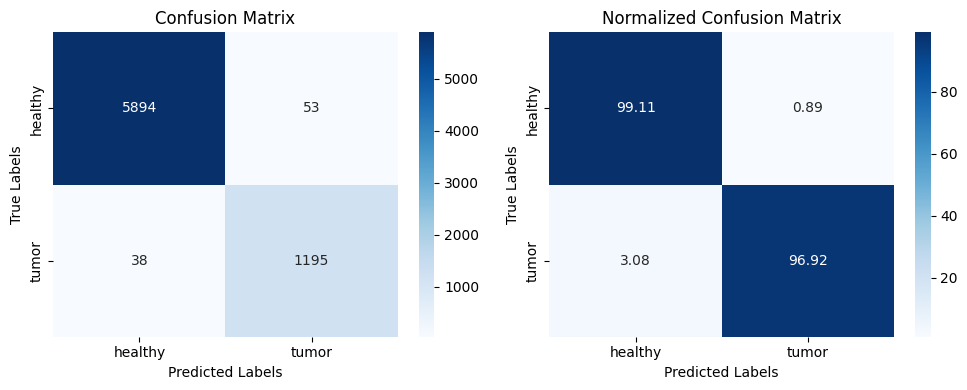

In [60]:
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix and normalized confusion matrix in subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted Labels")
ax[0].set_ylabel("True Labels")
cm_norm = (cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]) * 100
sns.heatmap(cm_norm, annot=True, cmap="Blues", ax=ax[1], xticklabels=class_names, yticklabels=class_names, fmt=".2f")
ax[1].set_title("Normalized Confusion Matrix")
ax[1].set_xlabel("Predicted Labels")
ax[1].set_ylabel("True Labels")
plt.tight_layout()
plt.show()

## ROC Curve

In [61]:
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

model_balanced = model.__class__(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)  
model_balanced.load_state_dict(torch.load(os.path.join(models_path, "binary_balanced_model.pth"), weights_only=True))
model_balanced.eval()

model_normal = model.__class__(spatial_dims=2, in_channels=3, out_channels=num_class).to(device)  
model_normal.load_state_dict(torch.load(os.path.join(models_path, "binary_unbalanced_model.pth"), weights_only=True))
model_normal.eval()

y_true = []
y_pred_prob_balanced = [] 
y_pred_prob_normal = []  

with torch.no_grad():
    test_progress = tqdm(test_loader, desc="Test evaluation", leave=True)
    for test_data in test_progress:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        
        # Modelo _balanced
        pred_logits_balanced = model_balanced(test_images)
        pred_probs_balanced = F.softmax(pred_logits_balanced, dim=1)[:, 1] 
        y_pred_prob_balanced.extend(pred_probs_balanced.cpu().numpy())
        
        # Modelo normal
        pred_logits_normal = model_normal(test_images)
        pred_probs_normal = F.softmax(pred_logits_normal, dim=1)[:, 1] 
        y_pred_prob_normal.extend(pred_probs_normal.cpu().numpy())
        
        # Etiquetas verdaderas
        y_true.extend(test_labels.cpu().numpy())

fpr_balanced, tpr_balanced, _ = roc_curve(y_true, y_pred_prob_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

fpr_normal, tpr_normal, _ = roc_curve(y_true, y_pred_prob_normal)
roc_auc_normal = auc(fpr_normal, tpr_normal)

target_spec = 0.85

fpr_idx_balanced = np.argmin(np.abs(fpr_balanced - (1 - target_spec)))  
sensitivity_at_spec85_balanced = tpr_balanced[fpr_idx_balanced]

fpr_idx_normal = np.argmin(np.abs(fpr_normal - (1 - target_spec)))  
sensitivity_at_spec85_normal = tpr_normal[fpr_idx_normal]

print()
print(30*"--")
print(f'AUC del modelo balanced: {roc_auc_balanced:.4f}')
print(f'Sensitivity given 85% specificity (balanced model): {sensitivity_at_spec85_balanced:.4f}')

print()
print(30*"--")
print(f'AUC del modelo normal: {roc_auc_normal:.4f}')
print(f'Sensitivity given 85% specificity (normal model): {sensitivity_at_spec85_normal:.4f}')

Test evaluation:   0%|          | 0/113 [00:00<?, ?it/s]


------------------------------------------------------------
AUC del modelo balanced: 0.9983
Sensitivity given 85% specificity (balanced model): 0.9976

------------------------------------------------------------
AUC del modelo normal: 0.9985
Sensitivity given 85% specificity (normal model): 0.9976


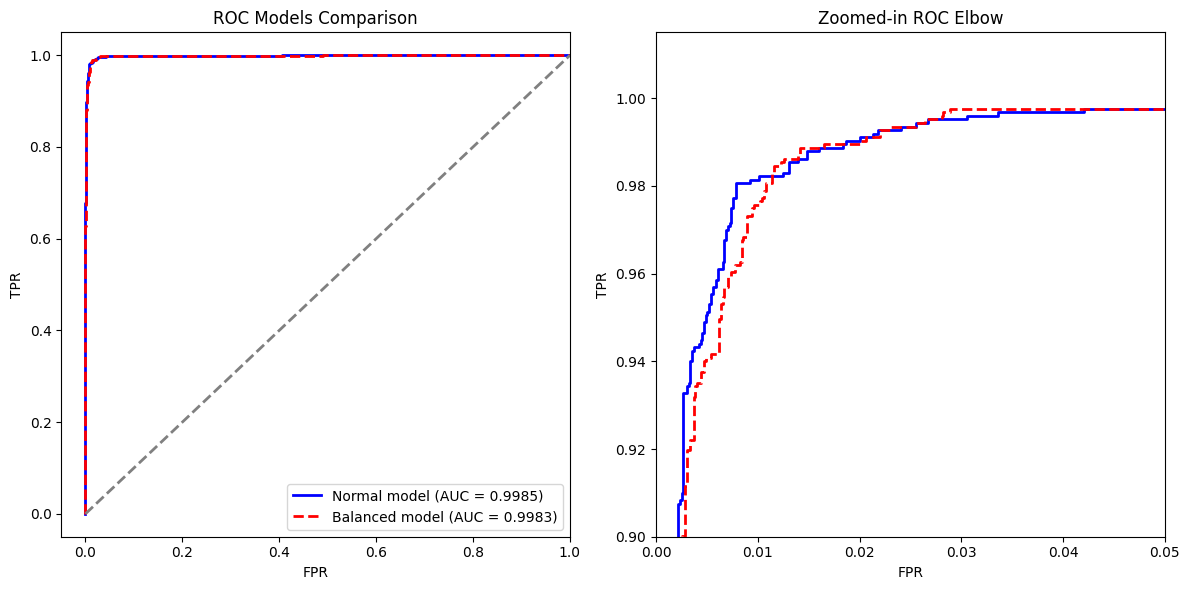

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(fpr_normal, tpr_normal, 'b', lw=2, label=f'Normal model (AUC = {roc_auc_normal:.4f})')
axes[0].plot(fpr_balanced, tpr_balanced, 'r--', lw=2, label=f'Balanced model (AUC = {roc_auc_balanced:.4f})')
axes[0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[0].set_xlim([-0.05, 1.0])
axes[0].set_ylim([-0.05, 1.05])
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC Models Comparison')
axes[0].legend(loc="lower right")

axes[1].plot(fpr_normal, tpr_normal, 'b', lw=2)
axes[1].plot(fpr_balanced, tpr_balanced, 'r--', lw=2, label='')
axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 0.05])
axes[1].set_ylim([0.9, 1.015])
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].set_title('Zoomed-in ROC Elbow')

plt.tight_layout()
plt.show()

## Activation maps

In [63]:
# Get layer names
for name, _ in model.named_modules():
    if any(f"denseblock{i}" in name for i in range(2, 4+1)):
        continue
    print(name)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.norm1
features.denseblock1.denselayer3.layers.relu1
features.denseblock1.denselayer3.layers.conv1


In [64]:
from monai.visualize import GradCAMpp

model.to(device)
model.load_state_dict(torch.load(os.path.join(models_path, "binary_balanced_model.pth"), weights_only=True))
model.eval()
print("Model loaded")

# usage reference
# gradcampp = GradCAMpp(model, target_layers="class_layers.relu")

Model loaded


In [65]:
def plot_gradcampp(orig_image_path, label):
    layers = [
        "features.transition1",
        "features.transition2",
        "features.transition3",
        "class_layers.relu",
    ]
    
    image = val_transforms(orig_image_path).unsqueeze(0).to(device)
    # Rotate the image 90 degrees
    image = torch.rot90(image, -1, [2, 3])
    # Flip the image horizontally
    image = torch.flip(image, [3])
    
    # Get prediction
    pred = model(image).argmax(dim=1).item()
    print(f"Prediction: {pred} ({class_names[pred]}) | Real Label: {label} ({class_names[label]})")

    # Generate GradCAM++ maps
    cams = [image[0][0].cpu()]  # Store original image
    for layer in layers:
        gradcampp = GradCAMpp(model, target_layers=layer)

        gradcam_map = gradcampp(image, label)
        gradcam_map = gradcam_map[0].cpu().numpy()
        gradcam_map = np.transpose(gradcam_map, (1, 2, 0))
        # gradcam_map = np.maximum(gradcam_map, 0)
        # gradcam_map = gradcam_map / gradcam_map.max()
        cams.append(gradcam_map)

    # Plot results
    plt.figure(figsize=(12, 6))
    titles = [f"Original ({class_names[label]})"] + layers
    for i in range(len(layers)+1):
        plt.subplot(1, len(layers)+1, i + 1)
        if i > 0:
            plt.imshow(cams[0], cmap="gray")  # Input image
            plt.imshow(cams[i], cmap="jet", alpha=0.5)  # GradCAM++
        else:
            plt.imshow(PIL.Image.open(orig_image_path))  # Input image
        plt.title(titles[i])  # Show layer name
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### CAM for all classes

Prediction: 0 (healthy) | Real Label: 0 (healthy)


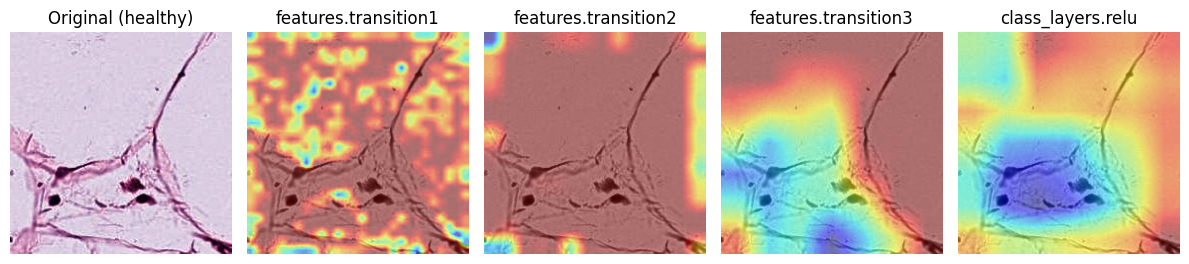

Prediction: 1 (tumor) | Real Label: 1 (tumor)


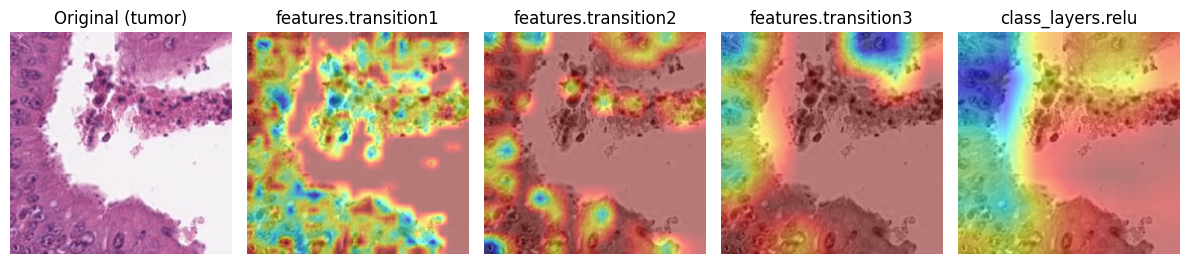

In [66]:
test_idx = 15

for i in range(num_class):
    image = test_image_files[i][test_idx]
    label = i

    plot_gradcampp(image, label)

### Tumor False Negatives

Tumor labeled images predicted as Healthy.

Prediction: 0 (healthy) | Real Label: 1 (tumor)


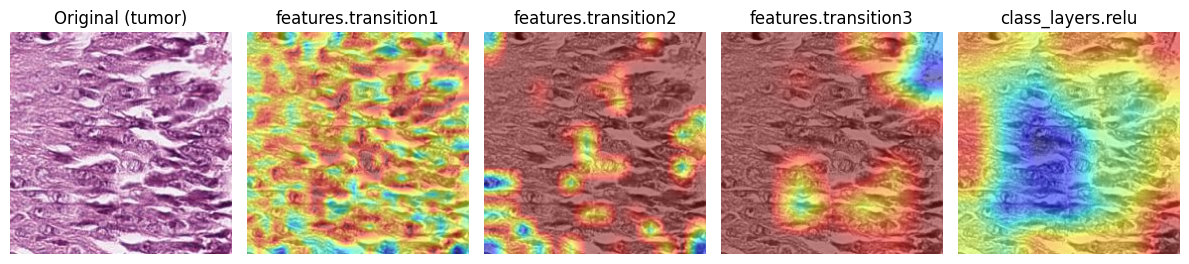

Prediction: 0 (healthy) | Real Label: 1 (tumor)


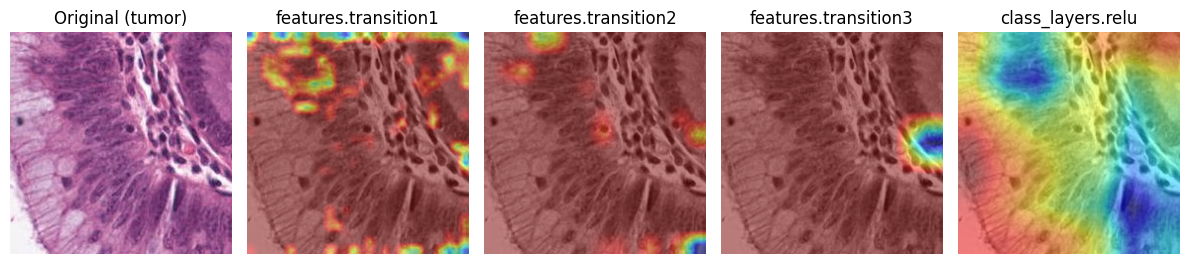

Prediction: 0 (healthy) | Real Label: 1 (tumor)


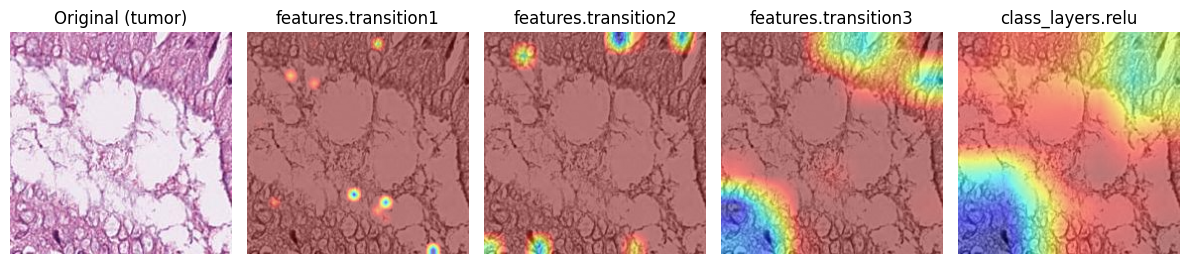

In [67]:
healthy_label = 0 # healthy
tumor_label = 1 # tumor

# Get 5 wrong predictions for the tumor class
wrong_preds = []
for i in range(len(y_true_test)):
    if y_true_test[i] == tumor_label and y_pred_test[i] == healthy_label:
        wrong_preds.append(i)
    if len(wrong_preds) == 3:
        break

# Plot GradCAM++ and CAM for the wrong predictions
for i in wrong_preds:
    image = image_files_list[i]
    label = y_true_test[i]

    plot_gradcampp(image, label)